In [27]:
# The Facial Point Detection competition
# Kaggle link to the competition: https://www.kaggle.com/competitions/facial-keypoints-detection

In [28]:
import torch
import os
import numpy as np
from fontTools.misc import transform
from torch import nn
from torch.nn import BatchNorm1d
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [29]:
def images_df_to_tensor(df):
    split_df = df['Image'].str.split(' ', expand=True)
    array = split_df.astype(np.float32).to_numpy()
    tensor = torch.tensor(array, dtype=torch.float32)
    tensor = tensor.reshape(-1, 1, 96, 96)
    return tensor

class FacialDataset(Dataset):
    def __init__(self, csv_path):
        self.images = pd.read_csv(csv_path)
        self.labels = self.images.drop("Image", axis=1)
        self.images = self.images[["Image"]]

        self.labels = torch.tensor(self.labels.values, dtype=torch.float32).squeeze() / 95 - 0.5
        self.images = images_df_to_tensor(self.images) / 255 - 0.5

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class UnlabeledFacialDataset(Dataset):
    def __init__(self, csv_path):
        self.images = pd.read_csv(csv_path)
        self.images = self.images[["Image"]]
        self.images = images_df_to_tensor(self.images) / 255 - 0.5

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

train_dataset = FacialDataset("data/training.csv")

generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(train_dataset, [0.80, 0.20], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [30]:
train_dataset.images.shape

torch.Size([7049, 1, 96, 96])

Feature batch shape: torch.Size([64, 1, 96, 96])
Labels batch shape: torch.Size([64, 30])
Feature batch shape: torch.Size([64, 1, 96, 96])


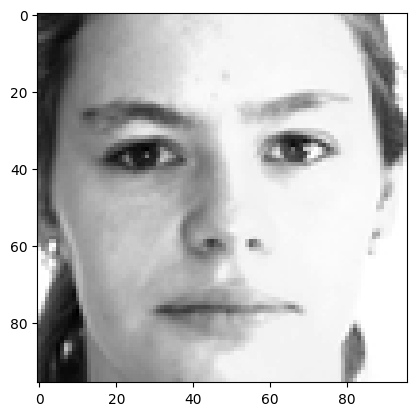

Label: tensor([ 0.2020, -0.1223, -0.2045, -0.1007,  0.1229, -0.1043,  0.2920, -0.1187,
        -0.1218, -0.1043, -0.2980, -0.0899,  0.0725, -0.2050,  0.3675, -0.2446,
        -0.0534, -0.1907, -0.3736, -0.1979,  0.0401,  0.1079,  0.2020,  0.3130,
        -0.1577,  0.3094,  0.0365,  0.2411,  0.0365,  0.3706])


In [31]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = (train_features[0].squeeze() + 0.5) * 255
label = train_labels[0]
print(f"Feature batch shape: {train_features.size()}")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [32]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.LeakyReLU(0.1)
        self.norm = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.linear(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features, 3)
        self.batchnorm = nn.BatchNorm2d(out_features)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_stack = nn.Sequential(
            ConvBlock(1, 2),
            ConvBlock(2, 4),
            nn.MaxPool2d(2),
            ConvBlock(4, 8),
            ConvBlock(8, 16),
            nn.MaxPool2d(2),
            ConvBlock(16, 16),
            ConvBlock(16, 32),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.block1 = LinearBlock(2048, 2048*2)
        self.block2 = LinearBlock(2048*2, 2048*2)
        self.block3 = LinearBlock(2048*2, 2048)
        self.block4 = LinearBlock(2048, 30)

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

model = NeuralNetwork().eval()
print(f"Model size {sum(p.numel() for p in model.parameters())}")

_ = model(train_dataset[0][0].unsqueeze(0))


Using cuda device
Model size 33655358


In [33]:
step_count = 0

train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    global step_count
    global train_accuracy, train_losses
    total_loss = 0
    total = 0
    curr_step_count = 0

    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()
        total += y.size(0)

        # Backpropagation
        loss.backward()
        optimizer.step()
        step_count += 1
        curr_step_count += 1
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"At step count {step_count}")

    train_losses.append(total_loss / curr_step_count)

def test(dataloader, model, loss_fn):
    global test_losses

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    test_losses.append(test_loss)

Start
Epoch 1
-------------------------------
Loss: 0.498663  [   64/ 7049]
At step count 1
Loss: 0.053815  [ 6464/ 7049]
At step count 101
Test Error: 
 Avg loss: 0.159349 

Epoch 2
-------------------------------
Loss: 0.068533  [   64/ 7049]
At step count 112
Loss: 0.036226  [ 6464/ 7049]
At step count 212
Test Error: 
 Avg loss: 0.052294 

Epoch 3
-------------------------------
Loss: 0.032184  [   64/ 7049]
At step count 223
Loss: 0.027348  [ 6464/ 7049]
At step count 323
Test Error: 
 Avg loss: 0.022759 

Epoch 4
-------------------------------
Loss: 0.031544  [   64/ 7049]
At step count 334
Loss: 0.024381  [ 6464/ 7049]
At step count 434
Test Error: 
 Avg loss: 0.048044 

Epoch 5
-------------------------------
Loss: 0.019833  [   64/ 7049]
At step count 445
Loss: 0.017163  [ 6464/ 7049]
At step count 545
Test Error: 
 Avg loss: 0.056012 

Epoch 6
-------------------------------
Loss: 0.031508  [   64/ 7049]
At step count 556
Loss: 0.034578  [ 6464/ 7049]
At step count 656
Test 

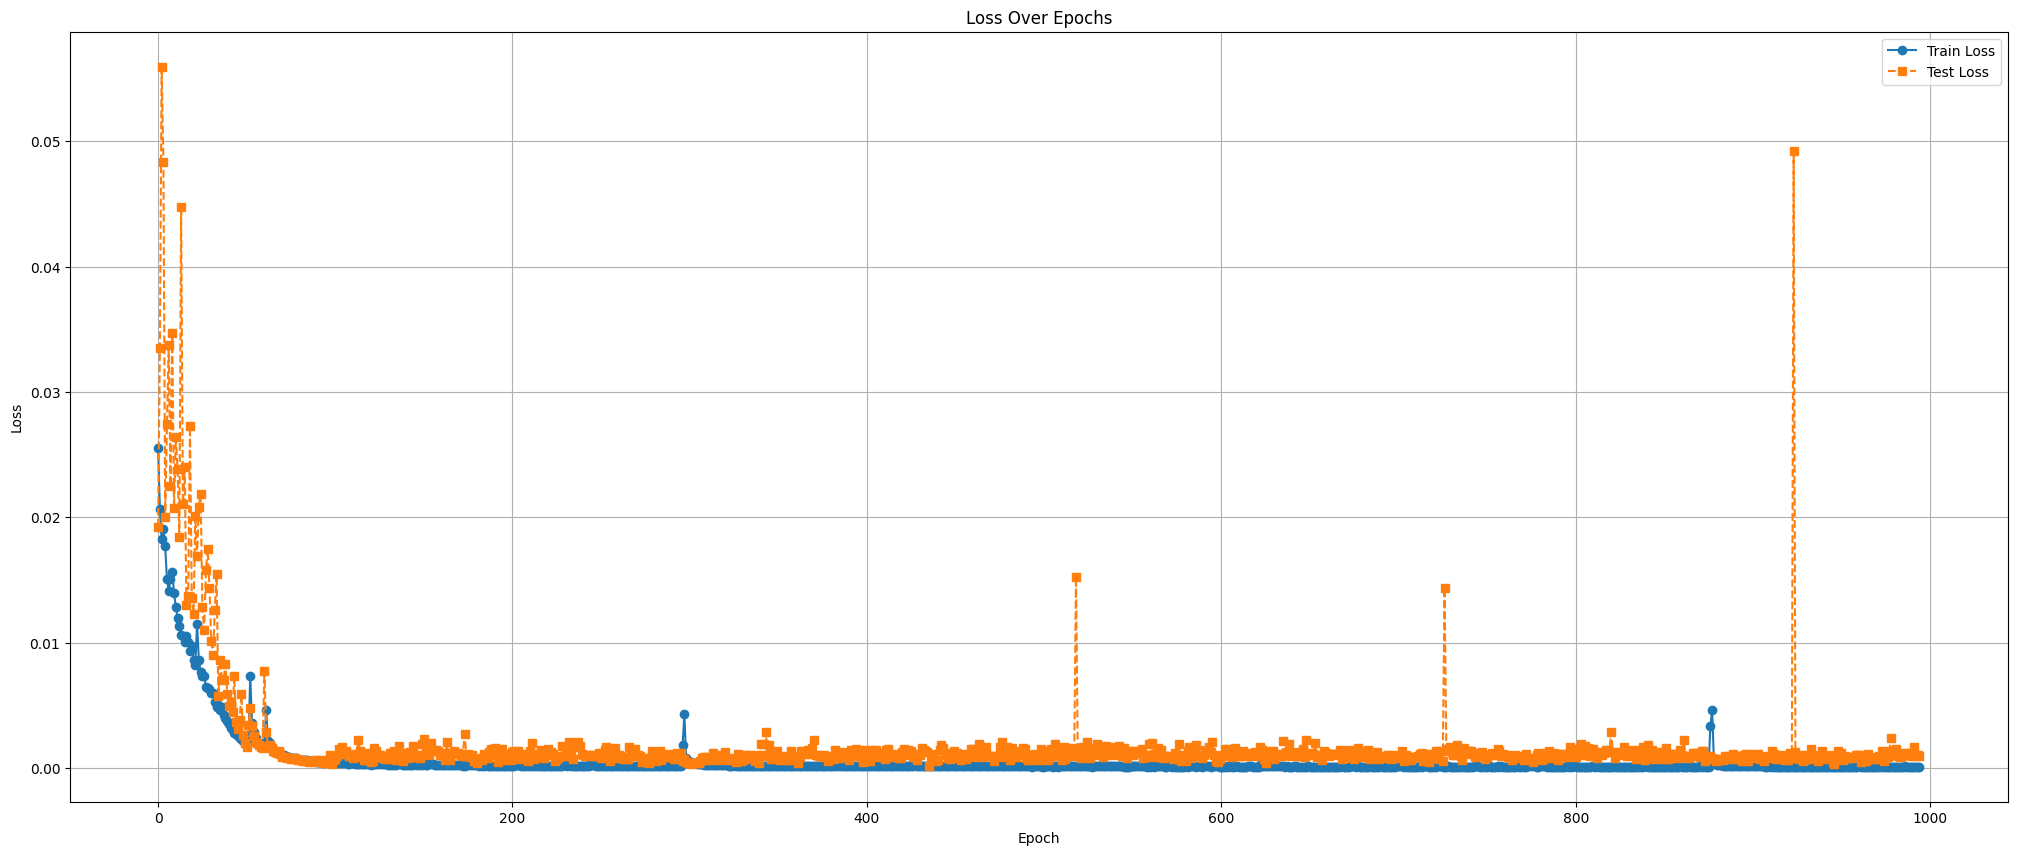

In [34]:
train_losses = []
test_losses = []

def plot_metrics():
    global train_losses, test_losses

    fig, ax = plt.subplots(1, 1, figsize=(25, 10))

    # Plot loss
    ax.plot(train_losses[10:], label='Train Loss', marker='o', linestyle='-')
    ax.plot(test_losses[10:], label='Test Loss', marker='s', linestyle='--')

    ax.set_title("Loss Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid()
    plt.show()

class loss_function(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, label, x):
        mask = ~torch.isnan(x)
        return self.mse_loss(x[mask], label[mask])

model = NeuralNetwork().to(device)
loss_fn = loss_function()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

epochs = 1000
print("Start")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

plot_metrics()

In [36]:
submission_loader = UnlabeledFacialDataset("data/test.csv")

features_list = [
    "left_eye_center_x", "left_eye_center_y",
    "right_eye_center_x", "right_eye_center_y",
    "left_eye_inner_corner_x", "left_eye_inner_corner_y",
    "left_eye_outer_corner_x", "left_eye_outer_corner_y",
    "right_eye_inner_corner_x", "right_eye_inner_corner_y",
    "right_eye_outer_corner_x", "right_eye_outer_corner_y",
    "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y",
    "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
    "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y",
    "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y",
    "nose_tip_x", "nose_tip_y",
    "mouth_left_corner_x", "mouth_left_corner_y",
    "mouth_right_corner_x", "mouth_right_corner_y",
    "mouth_center_top_lip_x", "mouth_center_top_lip_y",
    "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"
]

map_feature_to_index = {
    feature: i for i, feature in enumerate(features_list)
}

#Generate Submission
# Use the trained model to predict labels for unlabeled data
def predict_on_unlabeled_data(model, dataloader, device, test_format_file_name, output_file_name):
    model.eval()  # Set the model to evaluation mode
    image_index_to_prediction = {}

    with open(test_format_file_name, newline='') as csv_file:
        csv_reader = csv.DictReader(csv_file)

        with open(output_file_name, mode='w', newline='') as csvfile_out:
            writer = csv.DictWriter(csvfile_out, fieldnames=["RowId", "Location"])
            writer.writeheader()

            with torch.no_grad():
                for row in csv_reader:
                    image_id = int(row["ImageId"])
                    if image_id not in image_index_to_prediction:
                        model_prediction = model(dataloader[image_id-1].to(device).unsqueeze(0))
                        model_prediction = (model_prediction + 0.5) * 95
                        model_prediction = torch.clamp(model_prediction, min=0, max=95)
                        rounded_prediction = torch.round(model_prediction).to(torch.int)
                        image_index_to_prediction[image_id] = rounded_prediction.squeeze(0).cpu().numpy()

                    to_write_row = {}
                    to_write_row["RowId"] = row["RowId"]
                    to_write_row["Location"] = image_index_to_prediction[image_id][map_feature_to_index[row["FeatureName"]]]
                    writer.writerow(to_write_row)


predict_on_unlabeled_data(model, submission_loader, device, "IdLookupTable.csv", "submission.csv")
